In [24]:
from PIL import Image
import torch
from pypylon import pylon
import numpy as np
import cv2
from ctypes import *
import glob
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [8]:
def find_class(results, obj = 'car'):
    len_of_class = len(results.pred)
    pred_class = [int(results.pred[0][i].numpy()[5]) for i in range(len(results.pred[0]))]
    #list_of_yolo_classes = list(zip(results.names, range(0, len(results.names))))
    pred_names = [results.names[i] for i in pred_class]
    if obj in pred_names:
        index = pred_names.index(obj)
        return results.pred[0][index].numpy()
    else:
        return np.array([])

model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, pretrained=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\CIG/.cache\torch\hub\master.zip

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   

Adding autoShape... 


In [3]:
img_path = r'C:\Users\CIG\Documents\car_img_light'

In [3]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()       

In [10]:
camera.GainRaw.Value = 36
camera.ExposureTimeRaw.Value = 20000
camera.AcquisitionFrameRateAbs.Value = 10
camera.Width.Value = 417
camera.Height.Value = 404

In [5]:
# corning lib
lib = cdll.LoadLibrary(r"C:\Users\CIG\Documents\MATLAB\ComCasp64.dll")
#Check if Maxim driver dll is loaded
eCOMCaspErr = getattr(lib,'Casp_OpenCOM')
print('eCOMCaspErr:', eCOMCaspErr(), lib.Casp_OpenCOM())      

eCOMCaspErr: 0 0


In [6]:
img = pylon.PylonImage()
converter = pylon.ImageFormatConverter()

# converting to opencv bgr format
converter.OutputPixelFormat = pylon.PixelType_BGR8packed
converter.OutputBitAlignment = pylon.OutputBitAlignment_MsbAligned   

In [7]:
def grab_image(camera):
    #https://github.com/basler/pypylon/blob/master/samples/opencv.py
    camera.StartGrabbing()
    while 1:
        grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
        if grabResult.GrabSucceeded():
            # Access the image data
            image = converter.Convert(grabResult)
            image = image.GetArray()
#                 print(img[0])
#                 print('shape:', img.shape)
#                 plt.imshow(img)
            break
    camera.StopGrabbing()
    return image

In [ ]:
def make_imgs(camera, Exposure, path):
    camera.ExposureTimeRaw.Value = Exposure
    for i in range(24, 69):
        print(i)
        x = c_double(i)
        lib.Casp_SetFocusVoltage(x)
        time.sleep(2)

        img = grab_image(camera)
        image = Image.fromarray(img)
        filename = path + "\img_" + "_%s.png" % (str(i))
        image.save(filename)

In [7]:
def focus_value(im):
    # Calculate the gradient
    sobelx = cv2.Sobel(np.float32(im), cv2.CV_64F ,1 , 0, ksize=5)
    sobely = cv2.Sobel(np.float32(im),cv2.CV_64F,0,1,ksize=5)

    abs_sobel_x = cv2.convertScaleAbs(sobelx) # converting back to uint8
    abs_sobel_y = cv2.convertScaleAbs(sobely)
    #print(abs_sobel_x )

    # Combine the two gradients with equal weight
    dst = cv2.addWeighted(abs_sobel_x,0.5,abs_sobel_y,0.5,0)
    #print(dst)

    # Calculate the average gradient for the image
    # I convert it to a numpy array for ease of calculation
    return pl.asarray(dst).mean()

In [ ]:
#37.4

In [ ]:
#34 camera.ExposureTimeRaw.Value = 20000

In [ ]:
#34 camera.ExposureTimeRaw.Value = 112383

In [8]:
#camera.ExposureTimeRaw.Value = 112383

In [2]:
import glob

In [6]:
#open folder with images
#and save all images in the array

# images=glob.glob(r"C:\Users\CIG\Documents\car_img_light\34\*.png")
# stack_of_imgs_34 = []
# for image in images:
#     img = Image.open(image)
#     stack_of_imgs_34.append(img)

In [17]:
def stack_images_array(path):
    images=glob.glob(path + "\*.png")
    stack_of_imgs = []
    for image in images:
        img = Image.open(image)
        stack_of_imgs.append(img)
    return stack_of_imgs

def yolo_information(model_yolo, stack_of_imgs):
    imgs_stack_yolo = []
    for im in stack_of_imgs:
        results = model_yolo(im, size=640)  
        results.print()  # print results to screen
        #results.show()  # display results
        r = find_class(results, obj = 'car')
        if r.size == 0:
            imgs_stack_yolo.append(0)
        else:
            imgs_stack_yolo.append(im.crop((r[0], r[1], r[2], r[3])))
            
    return imgs_stack_yolo
            

def yolo_focus_value(imgs_stack_yolo):
    # Define containers
    average_gradient = []

    for im in imgs_stack_yolo:
        if im == 0:
            average_gradient.append(0)
        else:
            # Calculate the gradient
            sobelx = cv2.Sobel(np.float32(im), cv2.CV_64F ,1 , 0, ksize=5)
            sobely = cv2.Sobel(np.float32(im),cv2.CV_64F,0,1,ksize=5)

            abs_sobel_x = cv2.convertScaleAbs(sobelx) # converting back to uint8
            abs_sobel_y = cv2.convertScaleAbs(sobely)
            #print(abs_sobel_x )

            # Combine the two gradients with equal weight
            dst = cv2.addWeighted(abs_sobel_x,0.5,abs_sobel_y,0.5,0)
            #print(dst)

            # Calculate the average gradient for the image
            # I convert it to a numpy array for ease of calculation
            average_gradient.append(pl.asarray(dst).mean())
    return average_gradient

In [18]:
stack_of_imgs_34 = stack_images_array(path = r"C:\Users\CIG\Documents\car_img_light\34")
yolo_34 = yolo_information(model_yolo, stack_of_imgs_34)
yolo_34 = yolo_focus_value(yolo_34)

image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417


In [19]:
stack_of_imgs_34ex = stack_images_array(path = r"C:\Users\CIG\Documents\car_img_light\34_ex112383")
yolo_34ex = yolo_information(model_yolo, stack_of_imgs_34ex)
yolo_34ex = yolo_focus_value(yolo_34ex)

image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417 1 car
image 1/1: 404x417 1 car
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417


In [20]:
stack_of_imgs_37 = stack_images_array(path = r"C:\Users\CIG\Documents\car_img_light\37")
yolo_37 = yolo_information(model_yolo, stack_of_imgs_37)
yolo_37 = yolo_focus_value(yolo_37)

image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417 1 car
image 1/1: 404x417 1 car
image 1/1: 404x417 1 car
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417
image 1/1: 404x417


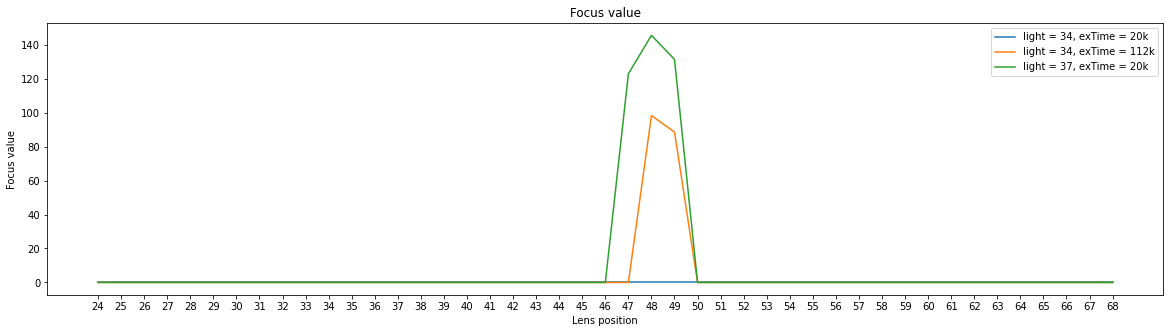

In [37]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(24, 69, step=1), yolo_34, label = 'light = 34, exTime = 20k')
plt.plot(np.arange(24, 69, step=1), yolo_34ex, label = 'light = 34, exTime = 112k')
plt.plot(np.arange(24, 69, step=1), yolo_37, label = 'light = 37, exTime = 20k')
plt.xticks(np.arange(24, 69, step=1))
plt.title("Focus value")
plt.xlabel('Lens position')
plt.ylabel('Focus value')
plt.legend()
#plt.savefig('focus_value.png')
plt.show()